# Proyecto - Optimización I
## Oscar Esaú Peralta Rosales y Stack Sánchez Pablo Antonio
### Maestría en computación - CIMAT

#### Parte 2: Pruebas y comparaciones

A continuación se presenta la implementación del paper *On the acceleration of the Barzilai-Borwein method*

Se puede acceder a él a través de:

https://arxiv.org/abs/2001.02335

In [0]:
from time import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
from scipy import linalg, optimize
import matplotlib.pyplot as plt

import rosembrock
import wood

Clase con los optimizadores

In [0]:
class ANGM():
    def __init__(self, ls_variant=0):
        self.__clear()
        self.ls_v = ls_variant


    def __clear(self):
        """ Reiniciliza los logs """
        self.x_log = []
        self.f_log = []
        self.g_norm_log = []
        self.x_best = None
        self.iters = 0

    def __get_q(self, g_k, gk_prev): 
        """ Retorna la aproximación a q como se define en el paper """
        zeros = g_k==0
        g_k[zeros] = 1
        qk = gk_prev**2 / g_k
        qk[zeros] = 0
        return qk

    def __get_alpha_sd(self, g_k, H_k): 
        """ Retorna el valor de alṕha para descenso de gradiente estándar """
        alpha_sd = g_k.dot(g_k) / g_k@H_k@g_k 
        return alpha_sd

    def __get_alpha_bb1(self, qk_prev, g_k, H_k): 
        """ Retorna el nuevo cálculo para BB1 propuesto """
        alpha_sd = 1/self.__get_alpha_sd(g_k, H_k)
        qAq = qk_prev@H_k@qk_prev
        qk_norm = qk_prev.dot(qk_prev)
        gk_norm = g_k.dot(g_k)
        qAg = qk_prev@H_k@g_k

        raiz = ((qAq/qk_norm - alpha_sd)**2 + 4*qAg / (qk_norm * gk_norm))
        den = qAq/qk_norm + alpha_sd + np.sqrt(raiz)

        return 2/den
    
    def __get_alpha_mg(self, g_k, H_k ): 
        """ Retorna el cálculo de alpha para minimal gradient """
        return (g_k@H_k@g_k) / (g_k@H_k@H_k@g_k)
    
    def __get_alpha_k(self, qk, H_k): 
        """ Retorna el cálculo de alpha gorrito para la obtencion de BB2 """
        return self.__get_alpha_mg(qk, H_k)

    def __get_gamma_k(self, qk_prev, g_k, H_k): 
        """ Retorna el valor de gamma usado para calcular BB2 """
        return 4 * (qk_prev@H_k@H_k@g_k)**2 / (qk_prev@H_k@qk_prev * g_k@H_k@g_k)

    def __get_alpha_bb2(self, qk_prev, H_k, g_k, alpha_k_prev, alpha_mg):
        """ Retorna la nueva aproximación a BB2 """
        alpha_mg = 1 / alpha_mg
        gamma_k = self.__get_gamma_k(qk_prev, g_k, H_k)
        alpha_k_prev = 1 / alpha_k_prev

        raiz= (alpha_k_prev - alpha_mg)**2 + gamma_k
        den = alpha_k_prev + alpha_mg + np.sqrt(np.abs(raiz))

        return 2 / den


    def optimize_BB_standard(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 a0: float = 0.001,
                 use_BB1 = True, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador de BB estandar 
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        x_k_prev =  None
        gk_prev= None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))


        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0

            if self.iters == 0 : 
                alpha_ok = a0
            else: 
                sk= x_k - x_k_prev
                yk= g_k - gk_prev
                if use_BB1: 
                    alpha_ok = sk.dot(sk)/sk.dot(yk)
                else: 
                    alpha_ok = sk.dot(yk)/yk.dot(yk)

            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

    def optimize_SDC(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador para SDC
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        


        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            
            alpha= g_k.dot(g_k)/g_k@H_k@g_k

            x_k = x_k - alpha* g_k

            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))


            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))

            self.iters +=1

        self.x_best = x_k

    def optimize_v1(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador para el método de ANGM
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None

        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_bb2 = None
        alpha_mg= self.__get_alpha_mg(g_k, H_k)

        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))


        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_prev = qk
                qk = self.__get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_prev = alpha_k
                alpha_k = self.__get_alpha_k(qk, H_k)
                alpha_ok = ak_bb1 
            if self.iters >= 2:
                alpha_bb2 = self.__get_alpha_bb2(qk_prev, H_k, g_k, alpha_k_prev, alpha_mg)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = alpha_bb2
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))
            alpha_mg= self.__get_alpha_mg(g_k, H_k)



            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k



    def optimize_v2(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador para ANGR1
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None
        qk_pprev = None
        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_k_pprev= None
        alpha_bb2 = None
        alpha_mg= self.__get_alpha_mg(g_k, H_k)
        H_k_prev= None
        alpha_ok =None 
        alpha_ok_prev=None

        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))


        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_pprev = qk_prev
                qk_prev = qk
                qk = self.__get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_pprev = alpha_k_prev
                alpha_k_prev = alpha_k
                alpha_k = self.__get_alpha_k(qk, H_k)
                alpha_ok = ak_bb1 
            if self.iters >= 3:
                alpha_bb2 = self.__get_alpha_bb2(qk_pprev, H_k_prev, gk_prev, alpha_k_pprev, ak_bb2)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = alpha_bb2
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k_prev = H_k
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))



            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

    def optimize_v3(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 h: np.array=None,
                 a0: float = 0.001,
                 t1: float = 0.1, 
                 t2: float = 1, 
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 **kwargs):
        """ Implementación del método optimizador para ANGR2
            Args:
                X: Punto inicial
                f: función objetivo
                g: Derivada de la función objetivo
                a0: Valor de tamaño de paso alpha inicial
                t1: Valor de tao 1 para el nuevo monotone stepsize BB2
                t2: Valor de tao 2 para el nuevo monotone stepsize BB2
                tol_g: Tolerancia para criterio con la norma del gradiente
                mxitr: Máximo número de iteraciones
                use_BB1: Inidica si se debe usar la fórmula BB1 sino se usa BB2
                kwargs:
                    f_kwargs: Diccionario con parámetros extra para la función objetivo
                    g_kwargs: Diccionario con parámetros extra para la derivada de la función objetivo
        """
        self.__clear()
        
        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        H_k = h(x_k, **kwargs.get('h_kwargs', {}))

        x_k_prev =  None
        gk_prev= None

        qk_prev = None
        qk = None
        alpha_k = None
        alpha_k_prev = None
        alpha_k_pprev=None
        alpha_bb2 = None
        alpha_mg= self.__get_alpha_mg(g_k, H_k)
        alpha_ok_prev = None
        ak_bb2 = None
        ak_bb2_prev = None
        ak_bb1=None
        alpha_ok = None
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))


        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            alpha_ok_prev = alpha_ok
            alpha_ok = a0
            
            if self.iters >= 1:
                qk_prev = qk
                qk = self.__get_q(g_k, gk_prev)
                sk= x_k - x_k_prev
                yk= g_k - gk_prev

                ak_bb1 = sk.dot(sk)/sk.dot(yk)
                ak_bb2_prev=ak_bb2
                ak_bb2 = sk.dot(yk)/yk.dot(yk)

                alpha_k_pprev = alpha_k_prev
                alpha_k_prev = alpha_k
                #alpha_k = self.__get_alpha_k(qk, H_k)
                alpha_k = alpha_ok_prev * qk.dot(qk - gk_prev) / (np.dot(qk - gk_prev,qk - gk_prev ))
                alpha_ok = ak_bb1 
            if self.iters >= 3:
                #alpha_bb2 = self.__get_alpha_bb2(qk_prev, H_k, g_k, alpha_k_prev, alpha_mg)

                if ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] < t2*self.g_norm_log[-1]: 
                    alpha_ok = min(ak_bb2, ak_bb2_prev)
                elif ak_bb2 < t1*ak_bb1 and self.g_norm_log[-2] >= t2*self.g_norm_log[-1]:
                    alpha_ok = min (ak_bb2, alpha_k_pprev)
                else: 
                    alpha_ok = ak_bb1


            x_k_prev = x_k
            x_k = x_k - alpha_ok * g_k

            gk_prev = g_k
            g_k =  g(x_k, **kwargs.get('g_kwargs', {}))
            H_k = h(x_k, **kwargs.get('h_kwargs', {}))
            alpha_mg= self.__get_alpha_mg(g_k, H_k)



            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k

## Prueba wood 


BB1
iters: 7234
g norm 8.965142796802929e-07
f error 5.579265043733195e-13
tiempo 0.33501482009887695


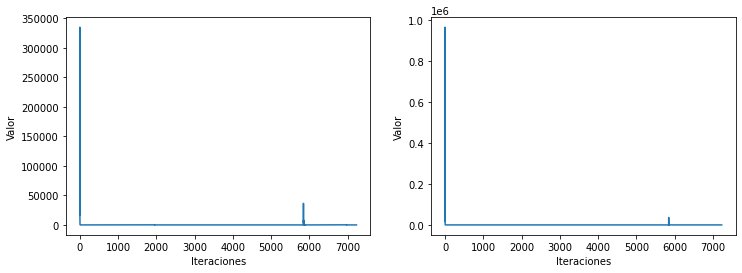

BB2
iters: 379
g norm 2.504969861907965e-07
f error 35.09003421043563
tiempo 0.028467893600463867


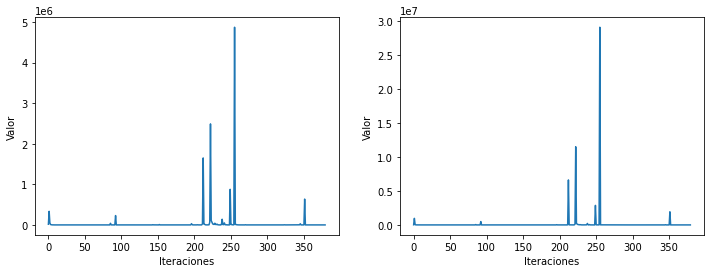

ANGM
iters: 242
g norm 2.6720616270798403e-09
f error 3.977053806482988e-21
tiempo 0.026175260543823242


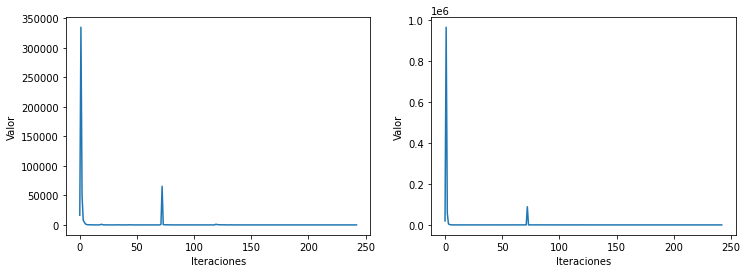

ANGR1
iters: 398
g norm 2.656040040611793e-07
f error 3.5262543575257513e-17
tiempo 0.03568887710571289


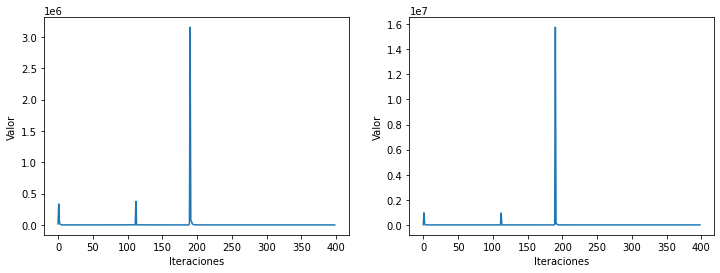

ANGR2
iters: 323
g norm 1.437261331913366e-07
f error 8.388255672359943e-17
tiempo 0.025421142578125


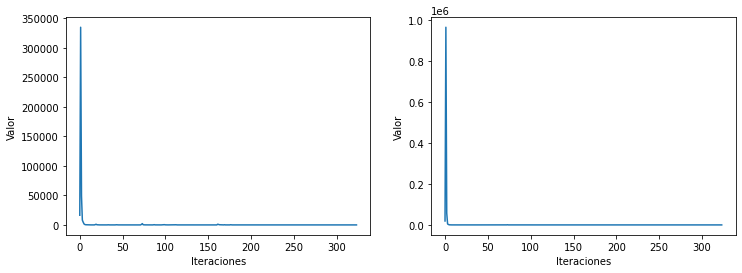

In [3]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)


xop = np.ones(4)


B_0 = wood.hessian(X)
H_0 = np.linalg.inv(B_0)

B_0 = np.identity(X.shape[0])

angm = ANGM()
for i in range(5): 
    if i==0: 
        print('BB1')
        params = {
        'X': X,
        'f': wood.function,
        'g': wood.gradient,
        'h': wood.hessian,
        'use_BB1': False, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
         }
        start_time = time()
        angm.optimize_BB_standard(**params)
        elapsed_time = time() - start_time
    if i==1: 
        print('BB2')
        params = {
        'X': X,
        'f': wood.function,
        'g': wood.gradient,
        'h': wood.hessian,
        'use_BB1': True, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
         }
        start_time = time()
        angm.optimize_BB_standard(**params)
        elapsed_time = time() - start_time
    if i==2:
        print('ANGM')
        start_time = time()
        angm.optimize_v1(**params) 
        elapsed_time = time() - start_time
    if i== 3: 
        print('ANGR1')
        start_time = time()
        angm.optimize_v2(**params)
        elapsed_time = time() - start_time
    if i== 4: 
        print('ANGR2')
        start_time = time()
        angm.optimize_v3(**params)
        elapsed_time = time() - start_time

    print("iters: %d" % angm.iters)
    print("g norm", np.linalg.norm(angm.g_norm_log[-1]))
    print("f error", angm.f_log[-1] - wood.function(xop))
    print("tiempo", elapsed_time)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(angm.g_norm_log)
    ax1.set(xlabel='Iteraciones', ylabel='Valor')
    ax2.plot(angm.f_log)
    ax2.set(xlabel='Iteraciones', ylabel='Valor')
    plt.show()

    angm.x_best

## Prueba Wood 100 iteraciones


In [4]:
angm = ANGM()
angmv2 = ANGM()
angmv3 = ANGM()




t1=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

print("Iter promedio, G_norm promedio, Tiempo promedio")
for j in range(t1.shape[0]): 
    ng_w1=[]
    it_w1=[]
    t_w1=[]

    ng_w2=[]
    it_w2=[]
    t_w2=[]

    ng_w3=[]
    it_w3=[]
    t_w3=[]
    for i in range(100):
        X = np.random.rand(4)
        params = {
            'X': X,
            'f': wood.function,
            'g': wood.gradient,
            'h': wood.hessian,
            'use_BB1': False, 
            'a0': 0.001,
            'tol_g': 1e-6,
            'mxitr': 10000,
            't1': t1[j],
            't2': 1,
        }
        start_time = time()
        angm.optimize_v1(**params)
        elapsed_time = time() - start_time

        ng_w1.append(np.linalg.norm(angm.g_norm_log[-1]))
        it_w1.append(angm.iters)
        t_w1.append(elapsed_time)

        start_time = time()
        angmv2.optimize_v2(**params)
        elapsed_time = time() - start_time

        ng_w2.append(np.linalg.norm(angmv2.g_norm_log[-1]))
        it_w2.append(angmv2.iters)
        t_w2.append(elapsed_time)

        start_time = time()
        angmv3.optimize_v3(**params)
        elapsed_time = time() - start_time

        ng_w3.append(np.linalg.norm(angmv3.g_norm_log[-1]))
        it_w3.append(angmv3.iters)
        t_w3.append(elapsed_time)





    print('\multicolumn{1}{|c|}{\\textit{',t1[j],'}} & \multicolumn{1}{c|}{',np.mean(it_w1),'} &', '\multicolumn{1}{c|}{',format(np.mean(ng_w1),'.3e'),'} &','\multicolumn{1}{c|}{',format(np.mean(t_w1),'.3e'),
          '}& \multicolumn{1}{c|}{',np.mean(it_w2),'} &', '\multicolumn{1}{c|}{',format(np.mean(ng_w2),'.3e'),'} &','\multicolumn{1}{c|}{',format(np.mean(t_w2),'.3e'), 
          '}& \multicolumn{1}{c|}{',np.mean(it_w3),'} &', '\multicolumn{1}{c|}{',format(np.mean(ng_w3),'.3e'),'} &','\multicolumn{1}{c|}{',format(np.mean(t_w3),'.3e'),'} \\\\ \hline')


Iter promedio, G_norm promedio, Tiempo promedio
\multicolumn{1}{|c|}{\textit{ 0.1 }} & \multicolumn{1}{c|}{ 187.87 } & \multicolumn{1}{c|}{ 4.368e-07 } & \multicolumn{1}{c|}{ 1.650e-02 }& \multicolumn{1}{c|}{ 221.13 } & \multicolumn{1}{c|}{ 4.137e-07 } & \multicolumn{1}{c|}{ 1.743e-02 }& \multicolumn{1}{c|}{ 188.12 } & \multicolumn{1}{c|}{ 4.299e-07 } & \multicolumn{1}{c|}{ 1.234e-02 } \\ \hline
\multicolumn{1}{|c|}{\textit{ 0.2 }} & \multicolumn{1}{c|}{ 176.61 } & \multicolumn{1}{c|}{ 3.759e-07 } & \multicolumn{1}{c|}{ 1.527e-02 }& \multicolumn{1}{c|}{ 176.99 } & \multicolumn{1}{c|}{ 3.626e-07 } & \multicolumn{1}{c|}{ 1.396e-02 }& \multicolumn{1}{c|}{ 127.55 } & \multicolumn{1}{c|}{ 3.245e-07 } & \multicolumn{1}{c|}{ 8.462e-03 } \\ \hline
\multicolumn{1}{|c|}{\textit{ 0.3 }} & \multicolumn{1}{c|}{ 80.72 } & \multicolumn{1}{c|}{ 3.442e-07 } & \multicolumn{1}{c|}{ 7.089e-03 }& \multicolumn{1}{c|}{ 87.86 } & \multicolumn{1}{c|}{ 3.411e-07 } & \multicolumn{1}{c|}{ 6.898e-03 }& \multicolum

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars


\multicolumn{1}{|c|}{\textit{ 0.8 }} & \multicolumn{1}{c|}{ 227.04 } & \multicolumn{1}{c|}{ 3.073e+06 } & \multicolumn{1}{c|}{ 2.005e-02 }& \multicolumn{1}{c|}{ 91.91 } & \multicolumn{1}{c|}{ 3.070e-07 } & \multicolumn{1}{c|}{ 7.343e-03 }& \multicolumn{1}{c|}{ 84.23 } & \multicolumn{1}{c|}{ 3.063e-07 } & \multicolumn{1}{c|}{ 5.675e-03 } \\ \hline
\multicolumn{1}{|c|}{\textit{ 0.9 }} & \multicolumn{1}{c|}{ 194.48 } & \multicolumn{1}{c|}{ 3.103e-07 } & \multicolumn{1}{c|}{ 1.727e-02 }& \multicolumn{1}{c|}{ 126.83 } & \multicolumn{1}{c|}{ 3.443e-07 } & \multicolumn{1}{c|}{ 1.022e-02 }& \multicolumn{1}{c|}{ 97.2 } & \multicolumn{1}{c|}{ 3.385e-07 } & \multicolumn{1}{c|}{ 6.549e-03 } \\ \hline


In [5]:
angmbb1 = ANGM()
angmbb2 = ANGM()

ng_w1=[]
it_w1=[]
t_w1=[]

ng_w2=[]
it_w2=[]
t_w2=[]

print("Iter promedio, G_norm promedio, Tiempo promedio")
for i in range(100):
    X = np.random.rand(4)
    params = {
        'X': X,
        'f': wood.function,
        'g': wood.gradient,
        'h': wood.hessian,
        'use_BB1': True, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
    }

    params2 = {
        'X': X,
        'f': wood.function,
        'g': wood.gradient,
        'h': wood.hessian,
        'use_BB1': False, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
    } 

    start_time = time()
    angmbb1.optimize_BB_standard(**params)
    elapsed_time = time() - start_time

    ng_w1.append(np.linalg.norm(angmbb1.g_norm_log[-1]))
    it_w1.append(angmbb1.iters)
    t_w1.append(elapsed_time)


    start_time = time()
    angmbb2.optimize_BB_standard(**params2)
    elapsed_time = time() - start_time

    ng_w2.append(np.linalg.norm(angmbb2.g_norm_log[-1]))
    it_w2.append(angmbb2.iters)
    t_w2.append(elapsed_time)

print(np.mean(it_w1), '&', format(np.mean(ng_w1),'.3e'), '& \multicolumn{1}{c|}{', format(np.mean(t_w1),'.3e'), '} &' ,np.mean(it_w2), '& \multicolumn{1}{c|}{', format(np.mean(ng_w2),'.3e'),'}    &',' \multicolumn{1}{c|}{', format(np.mean(t_w2),'.3e'), '} \\\\ \hline')






Iter promedio, G_norm promedio, Tiempo promedio
385.14 & 4.745e-07 & \multicolumn{1}{c|}{ 1.448e-02 } & 128.41 & \multicolumn{1}{c|}{ 5.337e-07 }    &  \multicolumn{1}{c|}{ 4.844e-03 } \\ \hline


## Prueba Rosembrock


BB1
iters: 1087
g norm 7.1881146028523370487e-07
f error 3.9866238543014484487
tiempo 1.4007575511932373


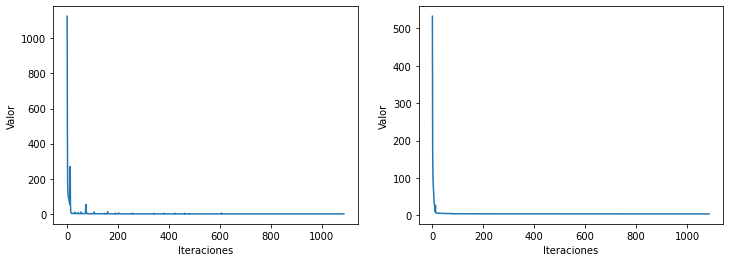

BB2
iters: 1012
g norm 9.564198597070266484e-07
f error 3.9866238543015936197
tiempo 1.2863354682922363


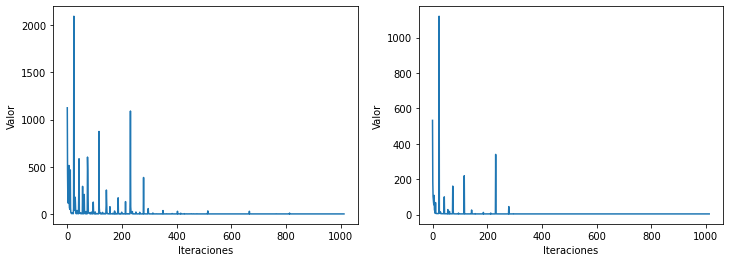

ANGM
iters: 329
g norm 8.224933669780788198e-07
f error 3.986623854300935313
tiempo 0.7626402378082275


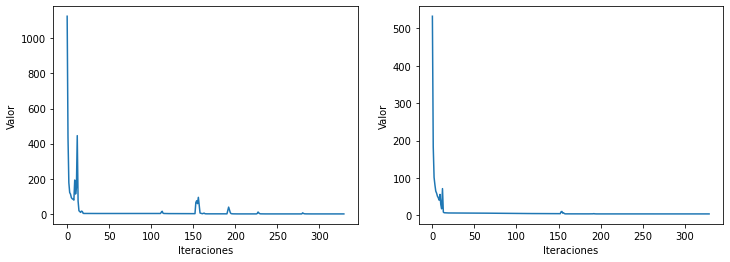

ANGR1
iters: 334
g norm 1.8129718626300773996e-07
f error 3.9866238543009337803
tiempo 0.7180533409118652


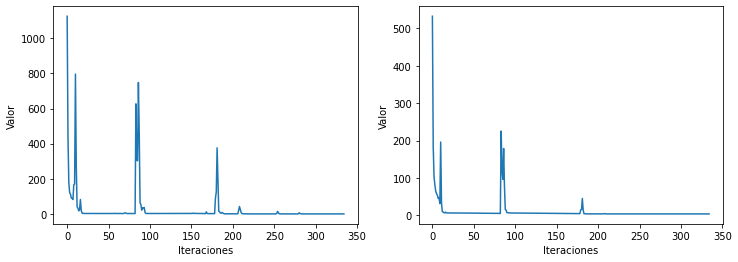

ANGR2
iters: 299
g norm 3.5563214578048358642e-07
f error 3.9866238543009338707
tiempo 0.5548915863037109


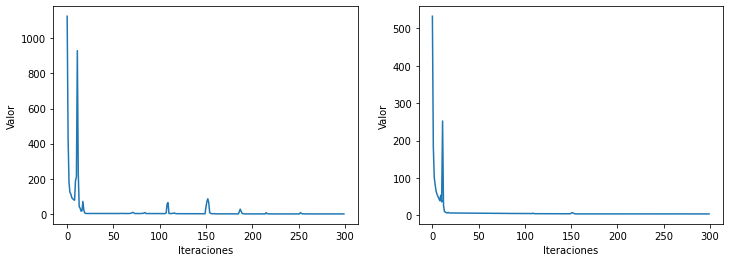

In [6]:
X = np.ones(100, dtype=np.float128)
X[0] = X[-2] = -1.2
#X = np.ones(100) + np.random.normal(size=100)

xop = np.ones(4)


B_0 = wood.hessian(X)
H_0 = np.linalg.inv(B_0)

B_0 = np.identity(X.shape[0])

angm = ANGM()
for i in range(5): 
    if i==0: 
        print('BB1')
        params = {
        'X': X,
        'f': rosembrock.function,
        'g': rosembrock.gradient,
        'h': rosembrock.hessian,
        'use_BB1': False, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
         }
        start_time = time()
        angm.optimize_BB_standard(**params)
        elapsed_time = time() - start_time
    if i==1: 
        print('BB2')
        params = {
        'X': X,
        'f': rosembrock.function,
        'g': rosembrock.gradient,
        'h': rosembrock.hessian,
        'use_BB1': True, 
        'a0': 0.001,
        'tol_g': 1e-6,
        'mxitr': 10000,
        't1': 0.4,
        't2': 1,
         }
        start_time = time()
        angm.optimize_BB_standard(**params)
        elapsed_time = time() - start_time
    if i==2:
        print('ANGM')
        start_time = time()
        angm.optimize_v1(**params) 
        elapsed_time = time() - start_time
    if i== 3: 
        print('ANGR1')
        start_time = time()
        angm.optimize_v2(**params)
        elapsed_time = time() - start_time
    if i== 4: 
        print('ANGR2')
        start_time = time()
        angm.optimize_v3(**params)
        elapsed_time = time() - start_time

    print("iters: %d" % angm.iters)
    print("g norm", np.linalg.norm(angm.g_norm_log[-1]))
    print("f error", angm.f_log[-1] - wood.function(xop))
    print("tiempo", elapsed_time)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(angm.g_norm_log)
    ax1.set(xlabel='Iteraciones', ylabel='Valor')
    ax2.plot(angm.f_log)
    ax2.set(xlabel='Iteraciones', ylabel='Valor')
    plt.show()